## Dataset

In [1]:
!pip install ipywidgets==8.0.4
!jupyter nbextension enable --py widgetsnbextension

!pip install more-itertools
!pip install plotly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.5.2
    Uninstalling widgetsnbextension-3.5.2:
      Successfully uninstalled widgetsnbextension-3.5.2
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.6.3
    Uninstalling ipywidgets-7.6.3:
      Successfully uninstalled ipywidgets-7.6.3
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 20.3 MB/s eta 0:00:0000:0100:01


In [5]:
import torch
import torch.nn as nn
import json
from datetime import datetime
from tqdm import tqdm

import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import more_itertools as mit
import time
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from spot import SPOT
from mtad_gat import MTAD_GAT
from trainer import Trainer
from predictor import Predictor
from utils import *
#from torch.utils.tensorboard import SummaryWriter
#da cambiare tensorboard con WandB

In [6]:
# da definire tutti manualmente, poi vedere valori di default in args

#dataset = args.dataset
window_size = 100
spec_res = False
normalize = False
n_epochs = 100
batch_size = 512
init_lr = 1e-3
val_split = 0.1
shuffle_dataset = False
use_cuda = True
print_every = 1
log_tensorboard = True
#group_index = args.group[0]True
#index = args.group[2:]
#args_summary = str(args.__dict__)
#print(args_summary)

## Dataset DataLoader e Training

#### Dataset Loading

In [7]:
#### Train

'''
# ottiene il dataset e lo mette in x_train
if dataset == 'SMD':
    output_path = f'output/SMD/{args.group}'
    (x_train, _), (x_test, y_test) = get_data(f"machine-{group_index}-{index}", normalize=normalize)
elif dataset in ['MSL', 'SMAP']:
    output_path = f'output/{dataset}'
    (x_train, _), (x_test, y_test) = get_data(dataset, normalize=normalize)
else:
    raise Exception(f'Dataset "{dataset}" not available.')
'''



# si crea la cartella di output
log_dir = './logs'
save_path = "./fv_model"

df = get_data()
for col in df:
    print(col)
timestamp = df["timestamp"] #salvo il timestamp per dopo
#df.set_index("timestamp", inplace=True)
df.drop(columns="timestamp", inplace=True)


train_data = df.to_numpy()
x_dim = len(df.columns)# numero di colonne
train_data = train_data.reshape((-1, x_dim))#[train_start:train_end, :]


scaler = MinMaxScaler().fit(train_data)
train_data = scaler.transform(train_data)



x_train, x_test = train_test_split(train_data, train_size=0.8, shuffle=False)

# converte il dataframe in un tensore
x_train = torch.from_numpy(x_train).float()

x_test = torch.from_numpy(x_test).float()


# Il secondo argomento del tensore sono il numero di colonne del dataframe
n_features = x_dim
print(f"feature numbers: {n_features}")
#funzione get_target_dims() in utils, ritorna il numero di dimesioni che devono essere modellate
# se none le modella TUTTE, quindi nel nostro caso = None
target_dims = None # if none models all features
out_dim = n_features

# inizializza la classe dataset di pythorch
train_dataset = SlidingWindowDataset(x_train, window_size, target_dims)
test_dataset = SlidingWindowDataset(x_test, window_size, target_dims)

## crea il dataframe
train_loader, val_loader, test_loader = create_data_loaders(
    train_dataset, batch_size, val_split, shuffle_dataset, test_dataset=test_dataset
)

# Inizializza il modello
model = MTAD_GAT(
    n_features,
    window_size,
    out_dim,
    kernel_size=7,
    use_gatv2=True,
    feat_gat_embed_dim=None,
    time_gat_embed_dim=None,
    gru_n_layers=2,
    gru_hid_dim=150,
    forecast_n_layers=3,
    forecast_hid_dim=150,
    recon_n_layers=1,
    recon_hid_dim=150,
    dropout=0.3,
    alpha=0.2
)

# inizializza optimizer e robe varie
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
forecast_criterion = nn.MSELoss()
recon_criterion = nn.MSELoss()

# altre robe di pytorch
trainer = Trainer(
    model,
    optimizer,
    window_size,
    n_features,
    target_dims,
    n_epochs,
    batch_size,
    init_lr,
    forecast_criterion,
    recon_criterion,
    use_cuda,
    save_path,
    log_dir,
    print_every,
    log_tensorboard=False
)

# Fa partire l'allenamento
#trainer.fit(train_loader, val_loader)

#plot_losses(trainer.losses, save_path=save_path, plot=False)


INV03_CurrentDC(A)
INV03_CurrentAC(A)
INV03_PowerAC(kW)
INV03_PowerDC(kW)
INV03_InternalTemperature(C)
INV03_HeatSinkTemperature(C)
INV03_VoltageDC(V)
INV03_VoltageAC(V)
INV02_CurrentDC(A)
INV02_CurrentAC(A)
INV02_PowerAC(kW)
INV02_PowerDC(kW)
INV02_InternalTemperature(C)
INV02_HeatSinkTemperature(C)
INV02_VoltageDC(V)
INV02_VoltageAC(V)
SOL_Irradiance(W/m2)
SOL_ModuleTemperature(C)
Cont_TotalEnergy(kWh)
Impianto_SolargisGHI(W/m2)
Impianto_SolargisGTI(W/m2)
minute_sin
minute_cos
hour_sin
hour_cos
day_sin
day_cos
month_sin
month_cos
relativehumidity_2m (%)
dewpoint_2m (°C)
rain (mm)
cloudcover (%)
soil_temperature_7_to_28cm (°C)
soil_moisture_7_to_28cm (m³/m³)
isday
timestamp
INV02_CommunicationCode_60
INV02_CommunicationCode_116
INV03_CommunicationCode_60
INV03_CommunicationCode_116
Cont_CommunicationCode_60
Cont_CommunicationCode_118
feature numbers: 42
train_size: 25744
validation_size: 2860
test_size: 7077


## Fit e Predict

Init total train loss: 0.923895
Init total val loss: 0.99825
Training model for 100 epochs..
[Epoch 1] forecast_loss = 0.30095, recon_loss = 0.29735, total_loss = 0.59830 ---- val_forecast_loss = 0.23803, val_recon_loss = 0.27259, val_total_loss = 0.51063 [5.4s]
[Epoch 2] forecast_loss = 0.20430, recon_loss = 0.19907, total_loss = 0.40337 ---- val_forecast_loss = 0.21103, val_recon_loss = 0.22920, val_total_loss = 0.44024 [5.4s]
[Epoch 3] forecast_loss = 0.18009, recon_loss = 0.17156, total_loss = 0.35166 ---- val_forecast_loss = 0.19058, val_recon_loss = 0.21061, val_total_loss = 0.40119 [5.5s]
[Epoch 4] forecast_loss = 0.16947, recon_loss = 0.16046, total_loss = 0.32993 ---- val_forecast_loss = 0.19244, val_recon_loss = 0.20754, val_total_loss = 0.39998 [5.3s]
[Epoch 5] forecast_loss = 0.16382, recon_loss = 0.15262, total_loss = 0.31643 ---- val_forecast_loss = 0.19109, val_recon_loss = 0.19915, val_total_loss = 0.39024 [5.5s]
[Epoch 6] forecast_loss = 0.15864, recon_loss = 0.14432, 

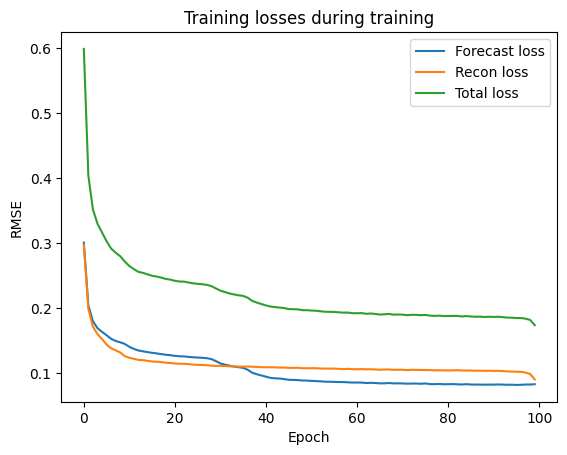

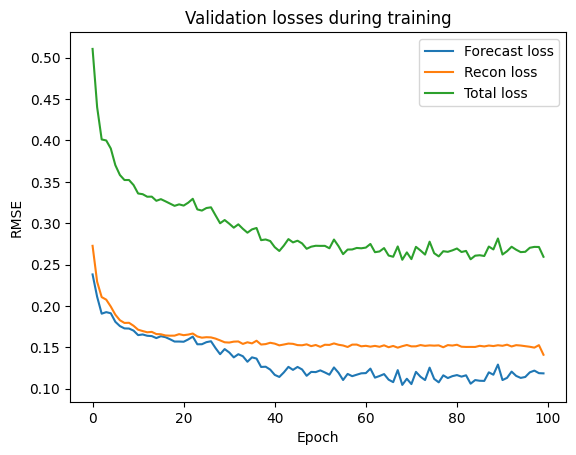

In [8]:
# Fa partire l'allenamento
trainer.fit(train_loader, val_loader)

plot_losses(trainer.losses, save_path=save_path, plot=True)


In [12]:
trainer.load(f"{save_path}/model.pt")
prediction_args = {
    "target_dims": target_dims,
    'scale_scores': False,
    "level": 0.90,
    "q": 1e-4,
    'dynamic_pot': False,
    "use_mov_av": False,
    "gamma": 0.9,
    "reg_level": 1,
    "save_path": save_path,
}
best_model = trainer.model
predictor = Predictor(
    best_model,
    window_size,
    n_features,
    prediction_args,
)
y_test=None

label = y_test[window_size:] if y_test is not None else None

predictor.predict_anomalies(x_train, x_test, label)


Predicting and calculating anomaly scores..


100%|██████████| 112/112 [00:06<00:00, 17.49it/s]


Predicting and calculating anomaly scores..


100%|██████████| 28/28 [00:01<00:00, 17.58it/s]


Running POT with q=0.0001, level=0.9..
Initial threshold : 0.030961082627375923
Number of peaks : 568
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.012271632871929672
	σ = 0.021442324208424388
	L = 1621.446980128866
Extreme quantile (probability = 0.0001): 0.14094624751528903


100%|██████████| 7077/7077 [00:01<00:00, 5445.66it/s]


0
7077
Results using epsilon method:
 {'threshold': 0.1173350028693676, 'reg_level': 1}
Results using peak-over-threshold method:
 {'threshold': 0.15214199639870019}
Results using best f1 score search:
 {}
Saving output to ./fv_model/<train/test>_output.pkl
-- Done.


In [ ]:
# Save config
args_path = "results/config.txt"
with open(args_path, "w") as f:
    json.dump(args.__dict__, f, indent=2)